<a href="https://colab.research.google.com/github/MichaelDeng03/GenAI_Agents/blob/main/all_agents_tutorials/art_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interactive Art Agent
This tutorial will walk through the creation of an AI Agent that helps you explore and learn art!

### Overview
For knowledge retrieval, this tutorial uses [LightRAG](https://github.com/HKUDS/LightRAG) which is knowledge graph based RAG implementation. Compared to GraphRAG, LightRAG is more accurate for single topic datasets, and uses 1,000x less tokens for retrieval. Furthermore, documents can be added to LightRAG incrementally without rebuilding the knowledge graph. See the full results in the [paper](https://arxiv.org/abs/2410.05779).

For the agent itself, we use LangGraph.

### Outline
0. [Setup](#setup)
1. [Data Preparation + RAG](#data-preparation--rag)
2. [Agent Creation](#agent-creation)
3. [Final App](#final-app)

### Setup

#### Environment

This tutorial uses openai embedding models. While there are alternatives, we recommend using the openai models for the best results.

```
export OPENAI_API_KEY=sk....
```

In [11]:
!uv pip install lightrag-hku aioboto3 numpy ollama openai tenacity aioboto3 transformers torch tiktoken nano_vectordb neo4j oracledb textract setuptools pyvis sqlalchemy langchain_community langchain_openai sqlmodel ipywidgets==7.7.1 asyncio markdown langgraph

Using Python 3.12.6 environment at /Users/kentgang/git2/GenAI_Agents/.venv
Resolved 185 packages in 253ms                                       
⠙ Preparing packages... (0/3)                                                   
⠙ Preparing packages... (0/3)-------     0 B/28.39 KiB                  
langgraph-sdk ------------------------------     0 B/28.39 KiB
⠙ Preparing packages... (0/3)----     0 B/121.96 KiB                    
langgraph-checkpoint ------------------------------     0 B/22.90 KiB
langgraph-sdk ------------------------------     0 B/28.39 KiB
⠙ Preparing packages... (0/3)----     0 B/121.96 KiB                    
langgraph-checkpoint ------------------------------     0 B/22.90 KiB
langgraph-sdk ------------------------------ 16.00 KiB/28.39 KiB
⠙ Preparing packages... (0/3)----     0 B/121.96 KiB                    
langgraph-checkpoint ------------------------------ 14.90 KiB/22.90 KiB
langgraph-sdk ------------------------------ 16.00 KiB/28.39 KiB
⠙ Preparing pa

In [1]:
from ipywidgets import Button, Layout, jslink, IntText, IntSlider, TwoByTwoLayout, Text, AppLayout, GridspecLayout
import ipywidgets as widgets
from IPython.display import display, Markdown
from IPython.display import Markdown

import json
import os
import operator
import random
from datetime import datetime
from typing import Any, Annotated, List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

from IPython.display import Image, display, Markdown

from langgraph.graph import StateGraph, END
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image as IPImage

from lightrag.llm import gpt_4o_mini_complete
from lightrag import LightRAG, QueryParam
from dotenv import load_dotenv

import markdown
from pprint import pprint

In [2]:
from io import BytesIO
from PIL import Image as PILImage


def get_artwork_image_url(url: str):
    """
    Gets an artwork image from its URL.
    """
    import requests
    from bs4 import BeautifulSoup as bs

    url = f"https://wikiart.org{url}"
    response = requests.get(url)
    soup = bs(response.text, "html.parser")
    img = soup.find("img", {"itemprop": "image"})
    # return Image(url=img.get("src"))

    return img.get("src")

### Data Preparation + RAG

#### Data Preparation

We scraped data from [wikiart](https://wikiart.org/) using a combination of requests and beautiful soup. 

We provide a preprocessed, limited dataset of this data for the tutorial found in `data/artinfo.json`. 

Preprocessed data for each artwork looks like:

```plaintext
Artwork Name: {artwork_name}
Artwork Genre: {genre_list}
Artwork Media: {media_list}
Wikiart URL: https://www.wikiart.org{wikiart_slug}

Wikipedia Article:
{wiki_article}
```


#### LightRAG


In [7]:
artwork_info = None
with open('./data/artinfo.json', 'r') as f:
    artwork_info = json.load(f)['info']
print(len(artwork_info))
print(artwork_info[0])

78

Artist: Frederick McCubbin
Artwork Name: Down on his luck
Artwork Genre: genre painting
Artwork Media: canvas,oil
Wikiart URL: https://www.wikiart.org/en/frederick-mccubbin/down-on-his-luck-1889

Wikipedia Article:
 The painting was owned by William Fergusson up to 1986 until it was purchased by the Art Gallery of Western Australia in Perth. for the famous 9 by 5 Impression Exhibition. The scene was staged near the Box Hill artists' camp outside Melbourne, but it is thought that McCubbin would have made additional studies of Abrahams under studio conditions.roclaims the absence of all self-pity ... McCubbin's picture is thoroughly Australian in spirit." The surrounding bush is painted in subdued tones, reflecting his somber and contemplative mood.



In [3]:
from lightrag.llm import gpt_4o_mini_complete
from lightrag import LightRAG, QueryParam

import nest_asyncio

nest_asyncio.apply()
WORKING_DIR = "./data"
rag = LightRAG(
    working_dir=WORKING_DIR,
    llm_model_func=gpt_4o_mini_complete,
)

INFO:lightrag:Logger initialized for working directory: ./data
INFO:lightrag:Load KV llm_response_cache with 178 data
INFO:lightrag:Load KV full_docs with 78 data
INFO:lightrag:Load KV text_chunks with 78 data
INFO:lightrag:Loaded graph from ./data/graph_chunk_entity_relation.graphml with 711 nodes, 642 edges
INFO:nano-vectordb:Load (709, 1536) data
INFO:nano-vectordb:Init {'embedding_dim': 1536, 'metric': 'cosine', 'storage_file': './data/vdb_entities.json'} 709 data
INFO:nano-vectordb:Load (642, 1536) data
INFO:nano-vectordb:Init {'embedding_dim': 1536, 'metric': 'cosine', 'storage_file': './data/vdb_relationships.json'} 642 data
INFO:nano-vectordb:Load (78, 1536) data
INFO:nano-vectordb:Init {'embedding_dim': 1536, 'metric': 'cosine', 'storage_file': './data/vdb_chunks.json'} 78 data


In [4]:
import time

# Create the RAG database
batch_size = 30

# Loop through the list in batches of 30 to avoid rate limits
for i in range(0, len(artwork_info), 30):
    batch = artwork_info[i:i + batch_size]
    rag.insert(batch)
    time.sleep(15)

NameError: name 'artwork_info' is not defined

### Agent Creation

In [8]:
class ArtTourState(TypedDict):
    artwork: str 
    artwork_metadata: str
    artwork_description: str
    artwork_url: str
    art_request: str
    past_artworks: list[str]
    discussion_messages: list[str]
    app_message: str  # intro and conclusion
    exit: bool

In [9]:
def get_artwork_url_from_name(state: ArtTourState):
    artwork_name = state['artwork']
    prompt = f"""
    What is the Wikiart URL for this artwork: {artwork_name}
    
    Return only the wikiart url in plain text.
    """
    return {"artwork_url": rag.query(prompt, param=QueryParam(mode="hybrid"))}
pprint(next_artwork_url := get_artwork_url_from_name({'artwork': "Down on his luck"}))

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Local query uses 60 entites, 67 relations, 10 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Global query uses 54 entites, 60 relations, 13 text units


{'artwork_url': 'https://www.wikiart.org/en/frederick-mccubbin/down-on-his-luck-1889'}


In [10]:
def describe_artwork(state: ArtTourState):
    artwork = state['artwork']
    metadata = rag.query(
        f"""What is the genre, media, and style of the following artwork: {artwork}. 
    Return the description in the following format:
    artwork name: <artwork name>
    artist: <artist>
    genre: <genre>
    media: <media>
    style: <style>
    
    Return this information and nothing else.
    """,
        param=QueryParam(mode="hybrid"),
    )

    dense_description = str(rag.query(f"Describe the imagery and context of {artwork} in 2 concise paragraphs.", param=QueryParam(mode="hybrid")))

    return {
        "artwork_metadata": metadata,
        "artwork_description": dense_description,
        "artwork_url": get_artwork_url_from_name(state)
    }
pprint(description := describe_artwork({"artwork": "Down on his luck"}))

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Local query uses 60 entites, 144 relations, 11 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Global query uses 44 entites, 60 relations, 12 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Local query uses 60 entites, 73 relations, 6 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Global query uses 49 entites, 60 relations, 9 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Local query uses 60 entites, 67 relations, 10 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Global query uses 54 entites, 60 relations, 13 text units


{'artwork_description': '"Down on His Luck" is an evocative 1889 painting by '
                        'Frederick McCubbin that portrays a disheartened '
                        'swagman sitting near a campfire, lost in thought amid '
                        'the natural Australian bush. The artwork captures the '
                        'intimate moment of despair, reflecting the hardships '
                        'faced by itinerant workers during the late 19th '
                        'century. The somber tones of the surrounding '
                        "landscape mirror the swagman's melancholic "
                        'expression, emphasizing the theme of isolation. '
                        "McCubbin's technique showcases his impressionist "
                        'style, with loose brushstrokes that evoke both the '
                        'vibrancy and desolation of the landscape, '
                        'highlighting the juxtaposition of human emotion '
              

In [12]:
def request_artwork(state: ArtTourState):
    description = state['art_request']
    prompt = """
    The user has requested the following for their next artwork. Choose a related artwork.
    {description}
    
    Return the name of the artwork and nothing else.
    """
    return {"artwork": rag.query(prompt, param=QueryParam(mode="hybrid"))}

def get_next_artwork(state: ArtTourState):
    
    prev_artwork = state['artwork_metadata']
    next_artwork = state['art_request']
    past_artworks = state['past_artworks']
    prompt = f"""You are an art tour guide. 
    The have discussed these artworks earlier in the tour: {past_artworks}  
    You just discussed this artwork:
    {prev_artwork}

    The user has requested the following for their next artwork. Choose a related artwork.
    {next_artwork}
    
    Return the name of the artwork and nothing else.
    """
    next_artwork = rag.query(prompt, param=QueryParam(mode="hybrid"))
    art_data = describe_artwork({'artwork': next_artwork})
    out =  {
        "artwork": next_artwork,
        "past_artworks": past_artworks + [prev_artwork],
        **art_data  # metadata + description
    }
    out.update(art_data)
    return out

# pprint(next_artwork := get_next_artwork({
#     "past_artworks": ["The Pink Dress", "The Ballet Class"],
#     "artwork_metadata": description['artwork_metadata'],
#     "art_request": "I want to see artworks by a different artist of the same genre."
# }))

In [13]:
with open('./data/artinfo.json', 'r') as f:
    art_json = json.load(f)
artworks = [art_info.split('\n')[2].split(': ')[1] for art_info in art_json['info']]
def get_random_art():
    out = {"artwork": random.sample(artworks, 1)[0]}
    art_data = describe_artwork(out)
    out.update(art_data)
    return out
# pprint(random_artwork := get_random_art())

In [14]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.tools import tool

In [ ]:
tour_instructions = """
You will be shown an artwork and a description.
Take a close look and articulate what you see, think, and feel.
Afterwards, you may describe an area of interest to continue exploring or view a new random artwork.
At the end, you'll be give a list of all the artworks you've seen.
"""

def tour_introduction(state: ArtTourState):
    out = get_random_art()
    out['app_message'] = tour_instructions
    return out

def conclude_tour(state: ArtTourState):
    summary = str(
        rag.query(
            f"""
            Build a narrative and summarize the themes of an art tour you just gave with these artworks
            {[state['artwork_metadata']] + state['past_artworks']}
            Start by writing a short introduction.
            Write no more than 2 sentences about any particular artwork.
            End by writing a short conclusion.
            Thank the user for their engagement.
            """,
            param=QueryParam(mode="hybrid")
        )
    )

    tour_conclusion = f"""
    Thank you for doing a tour!
    These are the artworks you viewed:
    {"\n".join(state['past_artworks'])}

    Here's a summary of the themes:
    {summary}
    """
    return {'app_message': tour_conclusion}

def display_artwork(state: ArtTourState):
    """
    Render the widgets
    """
    return state


def choose_next_artwork(state: ArtTourState):
    # Capture user message
    user_input = "I would like something more colorful"
    state['art_request'] = user_input
    return get_next_artwork(state)

def discuss(state: ArtTourState):
    """
    Discuss the artwork with the user
    """
    while True:
        # Capture user message
        user_input = "exit"

        if user_input == 'next':
            return state
        if user_input == 'exit':
            state['exit'] = True
            return state
        
        summary = str(
            rag.query(
                f"""
                The user has said:
                {user_input}
                about the artwork:
                {state['artwork']}

                Respond with 1-2 sentences enriching the user with new facts or feedback.
                """,
                param=QueryParam(mode="hybrid")
            )
        )
        # update widgets with summary text and repeat


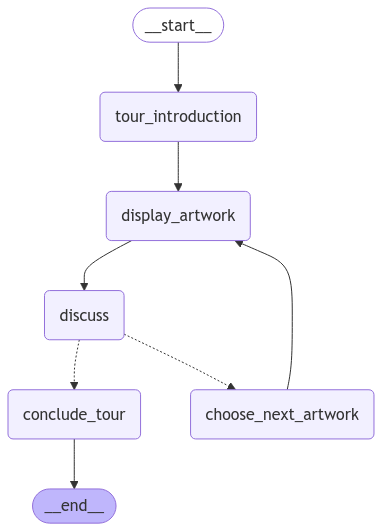

In [24]:

from typing import Literal


workflow = StateGraph(ArtTourState)
# nodes
workflow.add_node('tour_introduction', tour_introduction)
workflow.add_node('display_artwork', display_artwork)
workflow.add_node('choose_next_artwork', choose_next_artwork)

workflow.add_node('discuss', discuss)
workflow.add_node('conclude_tour', conclude_tour)

workflow.add_edge('tour_introduction', 'display_artwork')
workflow.add_edge('display_artwork', 'discuss')

workflow.add_edge('choose_next_artwork', 'display_artwork')
workflow.add_edge('conclude_tour', END)

def conclude_or_moreart(state: ArtTourState) -> Literal['conclude_tour', 'choose_next_artwork']:
    if state.get('exit'):
        return 'conclude_tour'
    return 'choose_next_artwork'

workflow.add_conditional_edges('discuss', conclude_or_moreart)

workflow.set_entry_point('tour_introduction')
app = workflow.compile()
display(
    IPImage(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [22]:
from langchain.globals import set_debug

set_debug(True)

In [25]:
app.invoke({"artwork": None, "past_artworks": []})

[chain/start] [chain:LangGraph] Entering Chain run with input:
{
  "artwork": null,
  "past_artworks": []
}
[chain/start] [chain:LangGraph > chain:__start__] Entering Chain run with input:
{
  "artwork": null,
  "past_artworks": []
}
[chain/end] [chain:LangGraph > chain:__start__] s] Exiting Chain run with output:
{
  "artwork": null,
  "past_artworks": []
}
[chain/start] [chain:LangGraph > chain:tour_introduction] Entering Chain run with input:
{
  "artwork": null,
  "past_artworks": []
}


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Local query uses 60 entites, 143 relations, 7 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Global query uses 58 entites, 60 relations, 14 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Local query uses 60 entites, 146 relations, 5 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Global query uses 28 entites, 60 relations, 7 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:

[chain/start] [chain:LangGraph > chain:tour_introduction > chain:ChannelWrite<tour_introduction,artwork,artwork_metadata,artwork_description,artwork_url,art_request,past_artworks,discussion_messages,app_message,exit>] Entering Chain run with input:
{
  "artwork": "Boulevard Montmartre Spring",
  "artwork_metadata": "```markdown\nartwork name: Boulevard Montmartre Spring  \nartist: Camille Pissarro  \ngenre: cityscape  \nmedia: canvas, oil  \nstyle: Impressionism  \n```",
  "artwork_description": "**Imagery of Boulevard Montmartre Spring**\n\n\"**Boulevard Montmartre Spring**,\" painted by Camille Pissarro in 1897, beautifully illustrates a lively street scene during the spring season in a bustling Paris. The canvas captures a vibrant array of colors that depict blossoming trees and the activity of people strolling along the boulevard. The use of pointillism is evident in Pissarro's brush strokes, conveying the energetic atmosphere while also highlighting the interplay of light and shad

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Local query uses 60 entites, 151 relations, 6 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Global query uses 37 entites, 60 relations, 9 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[chain/start] [chain:LangGraph > chain:conclude_tour > chain:ChannelWrite<conclude_tour,artwork,artwork_metadata,artwork_description,artwork_url,art_request,past_artworks,discussion_messages,app_message,exit>] Entering Chain run with input:
{
  "app_message": "\n    Thank you for doing a tour!\n    These are the artworks you viewed:\n    \n\n    Here's a summary of the themes:\n    # Art Tour Narrative\n\nWelcome to our enlightening art tour, where we explored some remarkable works of art that define and illustrate the evolution of Impressionism and its impact on the art world. From the vibrant landscapes of Claude Monet to the poignant social commentaries of Édouard Manet, we traversed a rich landscape of creativity and expression.\n\n**1. The Grand Canal 03** by Claude Monet captures the ethereal beauty of Venice, showcasing Monet's mastery of light and color as he paints the changing reflections on the water. This series exemplifies his exploration of natural light, inviting viewers

{'artwork': 'Boulevard Montmartre Spring',
 'artwork_metadata': '```markdown\nartwork name: Boulevard Montmartre Spring  \nartist: Camille Pissarro  \ngenre: cityscape  \nmedia: canvas, oil  \nstyle: Impressionism  \n```',
 'artwork_description': '**Imagery of Boulevard Montmartre Spring**\n\n"**Boulevard Montmartre Spring**," painted by Camille Pissarro in 1897, beautifully illustrates a lively street scene during the spring season in a bustling Paris. The canvas captures a vibrant array of colors that depict blossoming trees and the activity of people strolling along the boulevard. The use of pointillism is evident in Pissarro\'s brush strokes, conveying the energetic atmosphere while also highlighting the interplay of light and shadows as sunlight filters through the foliage. The painting evokes a sense of vitality and joy as figures engage in leisure activities, characteristic of the social and cultural life in Paris during this time.\n\n**Context of the Artwork**\n\nThe painting h

### Final App

In [ ]:
def create_image_widget(artwork_url: str):
    return widgets.HTML(value=f'<img src="{get_artwork_image_url(artwork_url)}">')


def create_description_box(description: str):
    return widgets.HTML(markdown.markdown(description))
    # return widgets.HTML(value=f'<h1>{description}</h1>')


exit_loop = False

prompt_input = widgets.Text(value='helloworld')


def callback(widget):
    # Start workflow loop
    pass


prompt_input.on_submit(callback)

grid_layout = GridspecLayout(20, 1)
grid_layout[0, 0] = create_description_box("foo 1637")
grid_layout[1:12, 0] = create_image_widget('/en/pieter-codde/the-meagre-company-1637')
grid_layout[13, 0] = create_description_box("this is a llm response")
grid_layout[14, 0] = prompt_input

grid_layout

GridspecLayout(children=(HTML(value='<p>foo 1637</p>', layout=Layout(grid_area='widget001')), HTML(value='<img…

In [ ]:
# User Loop
current_image = "https://www.wikiart.org/en/pierre-auguste-renoir/ball-at-the-moulin-de-la-galette-1876"
description = describe_painting(current_image)
app_running = True
while app_running:
    while current_painting:
        

    